<a href="https://colab.research.google.com/github/Yasminebenhamadi/NMA/blob/main/DL/W2D4_Tutorial3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial 3: Conditional GANs and Implications of GAN Technology

**Week 2, Day 4: Generative Models**

**By Neuromatch Academy**

__Content creators:__ Seungwook Han, Kai Xu, Akash Srivastava

__Content reviewers:__ Polina Turishcheva, Melvin Selim Atay, Hadi Vafaei, Deepak Raya, Kelson Shilling-Scrivo

__Content editors:__ Spiros Chavlis

__Production editors:__ Arush Tagade, Gagana B, Spiros Chavlis

---
# Setup

In [ ]:
# @title Install dependencies
# @markdown Install *Huggingface BigGAN* library
!pip install pytorch-pretrained-biggan --quiet
!pip install Pillow libsixel-python --quiet
!pip install nltk --quiet

!pip install git+https://github.com/NeuromatchAcademy/evaltools --quiet

from evaltools.airtable import AirtableForm
atform = AirtableForm('appn7VdPRseSoMXEG', 'W2D4_T3','https://portal.neuromatchacademy.org/api/redirect/to/ddf809a2-5590-4d71-a764-1572e85dce27')

     |████████████████████████████████| 132 kB 50.0 MB/s 
     |████████████████████████████████| 79 kB 2.8 MB/s 
     |████████████████████████████████| 9.1 MB 48.5 MB/s 
     |████████████████████████████████| 140 kB 71.4 MB/s 
     |████████████████████████████████| 127 kB 70.8 MB/s 


In [ ]:
# Imports
import torch
import torchvision

import numpy as np
import matplotlib.pyplot as plt

from pytorch_pretrained_biggan import BigGAN
from pytorch_pretrained_biggan import one_hot_from_names
from pytorch_pretrained_biggan import truncated_noise_sample

In [ ]:
# @title Figure settings
import ipywidgets as widgets       # Interactive display
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/content-creation/main/nma.mplstyle")

In [ ]:
# @title Set random seed

# @markdown Executing `set_seed(seed=seed)` you are setting the seed

# for DL its critical to set the random seed so that students can have a
# baseline to compare their results to expected results.
# Read more here: https://pytorch.org/docs/stable/notes/randomness.html

# Call `set_seed` function in the exercises to ensure reproducibility.
import random
import torch

def set_seed(seed=None, seed_torch=True):
  """
  Function that controls randomness. NumPy and random modules must be imported.

  Args:
    seed : Integer
      A non-negative integer that defines the random state. Default is `None`.
    seed_torch : Boolean
      If `True` sets the random seed for pytorch tensors, so pytorch module
      must be imported. Default is `True`.

  Returns:
    Nothing.
  """
  if seed is None:
    seed = np.random.choice(2 ** 32)
  random.seed(seed)
  np.random.seed(seed)
  if seed_torch:
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

  print(f'Random seed {seed} has been set.')


# In case that `DataLoader` is used
def seed_worker(worker_id):
  """
  DataLoader will reseed workers following randomness in
  multi-process data loading algorithm.

  Args:
    worker_id: integer
      ID of subprocess to seed. 0 means that
      the data will be loaded in the main process
      Refer: https://pytorch.org/docs/stable/data.html#data-loading-randomness for more details

  Returns:
    Nothing
  """
  worker_seed = torch.initial_seed() % 2**32
  np.random.seed(worker_seed)
  random.seed(worker_seed)

In [ ]:
# @title Set device (GPU or CPU). Execute `set_device()`
# especially if torch modules used.

# Inform the user if the notebook uses GPU or CPU.

def set_device():
  """
  Set the device. CUDA if available, CPU otherwise

  Args:
    None

  Returns:
    Nothing
  """
  device = "cuda" if torch.cuda.is_available() else "cpu"
  if device != "cuda":
    print("WARNING: For this notebook to perform best, "
        "if possible, in the menu under `Runtime` -> "
        "`Change runtime type.`  select `GPU` ")
  else:
    print("GPU is enabled in this notebook.")

  return device

In [ ]:
SEED = 2021
set_seed(seed=SEED)
DEVICE = set_device()

Random seed 2021 has been set.
GPU is enabled in this notebook.


In [ ]:
# @title Download `wordnet` dataset

# import nltk
# nltk.download('wordnet')

import os, requests, zipfile

os.environ['NLTK_DATA'] = 'nltk_data/'

fnames = ['wordnet.zip', 'omw-1.4.zip']
urls = ['https://osf.io/ekjxy/download', 'https://osf.io/kuwep/download']

for fname, url in zip(fnames, urls):
  r = requests.get(url, allow_redirects=True)

  with open(fname, 'wb') as fd:
    fd.write(r.content)

  with zipfile.ZipFile(fname, 'r') as zip_ref:
    zip_ref.extractall('nltk_data/corpora')

---
# Section 1: Generating with a conditional GAN (BigGAN)

In [ ]:
def load_biggan(model_res):
  """
  Load respective BigGAN model for the specified resolution (biggan-deep-128, biggan-deep-256, biggan-deep-512)
  """
  return BigGAN.from_pretrained('biggan-deep-{}'.format(model_res))


def create_class_noise_vectors(class_str, trunc, num_samples):
  """
  Create class and noise vectors for sampling from BigGAN

  Args:
    class_str: string
      Class
    trunc: float
      Truncation factor
    num_samples: int
      Number of samples

  Returns:
    class_vector: np.ndarray
      Class vector sampled from BigGan
    noise_vector: np.ndarray
      Noise vector
  """
  class_vector = one_hot_from_names([class_str]*num_samples, batch_size=num_samples)
  noise_vector = truncated_noise_sample(truncation=trunc, batch_size=num_samples)

  return class_vector, noise_vector

def generate_biggan_samples(model, class_vector, noise_vector, device,
                            truncation=0.4):
  """
  Generate samples from BigGAN

  Args:
    model: nn.module
      Model
    device: string
      GPU if available. CPU otherwise.
    truncation: float
      Truncation factor
    class_vector: np.ndarray
      Class vector sampled from BigGan
    noise_vector: np.ndarray
      Noise vector

  Returns:
    output_grid: torch.tensor
      Make grid and display generated samples
  """
  # Convert to tensor
  noise_vector = torch.from_numpy(noise_vector)
  class_vector = torch.from_numpy(class_vector)

  # Move to GPU
  noise_vector = noise_vector.to(device)
  class_vector = class_vector.to(device)
  model.to(device)

  # Generate an image
  with torch.no_grad():
      output = model(noise_vector, class_vector, truncation)

  # Back to CPU
  output = output.to('cpu')

  # The output layer of BigGAN has a tanh layer, resulting the range of [-1, 1] for the output image
  # Therefore, we normalize the images properly to [0, 1] range.
  # Clipping is only in case of numerical instability problems

  output = torch.clip(((output.detach().clone() + 1) / 2.0), 0, 1)
  output = output

  # Make grid and show generated samples
  output_grid = torchvision.utils.make_grid(output,
                                            nrow=min(4, output.shape[0]),
                                            padding=5)
  plt.imshow(output_grid.permute(1, 2, 0))

  return output_grid


def generate(b):
  """
  Generation function

  Args:
    None

  Returns:
    Nothing
  """
  # Create BigGAN model
  model = load_biggan(MODEL_RESOLUTION)

  # Use specified parameters (resolution, class, number of samples, etc) to generate from BigGAN
  class_vector, noise_vector = create_class_noise_vectors(CLASS, TRUNCATION,
                                                          NUM_SAMPLES)
  samples_grid = generate_biggan_samples(model, class_vector, noise_vector,
                                         DEVICE, TRUNCATION)
  torchvision.utils.save_image(samples_grid, 'samples.png')
  ### If CUDA out of memory issue, lower NUM_SAMPLES (number of samples)

## Section 1.1:  Define configurations

In [ ]:
# @title { run: "auto" }

### RUN THIS BLOCK EVERY TIME YOU CHANGE THE PARAMETERS FOR GENERATION

# Resolution at which to generate
MODEL_RESOLUTION = "128" # @param [128, 256, 512]

# Number of images to generate
NUM_SAMPLES = 4 # @param {type:"slider", min:4, max:12, step:4}

# Class of images to generate
CLASS = 'German shepherd'  # @param ['tench', 'magpie', 'jellyfish', 'German shepherd', 'bee', 'acoustic guitar', 'coffee mug', 'minibus', 'monitor']

# Truncation level of the normal distribution we sample z from
TRUNCATION = 1  # @param {type:"slider", min:0.1, max:1, step:0.1}

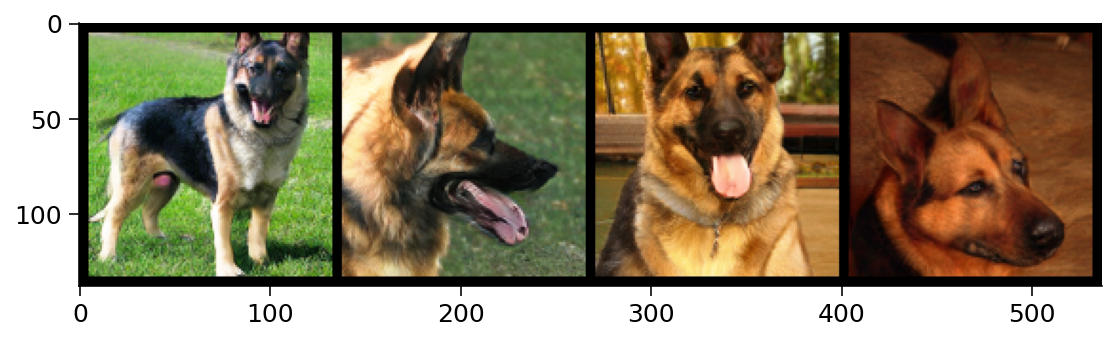

Button(button_style='danger', description='GENERATE!', layout=Layout(height='80px', width='30%'), style=Button…

Output()

In [ ]:
# @title Generate
# Create generate button, given parameters specified above
button = widgets.Button(description="GENERATE!",
                        layout=widgets.Layout(width='30%', height='80px'),
                        button_style='danger')
output = widgets.Output()
display(button, output)
button.on_click(generate)